In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch 
from torch.autograd import Variable 
import torch.optim as optim 
from torch.utils.data import DataLoader 
from torchvision import transforms
import csv
from torch.utils.data.dataset import Dataset 
import torch.nn as nn 
import torch.nn.functional as F

# 1. Load the data
For more details on how data is loaded, please see `subroutines.py`.

In [2]:
def return_HM_npy(csvfile_path):
    Hs = []
    Ms = []
    with open(csvfile_path, 'r') as f:
        reader = csv.reader(f)
        header = next(reader)  # Skipping the header
        for row in reader:
            Hs.append(float(row[0]))
            Ms.append(float(row[1]))
    return np.array(Hs), np.array(Ms)

def accept_test_middle(H, M, noise_std=0.01, f=None):
    noise = abs(np.random.normal(0, noise_std))
    if (f(H)-noise < M) and (M < f(H)+noise):
        return True
    else:
        return False

def generate_training_data(noise_std=0.004, data_size=10000, Hrange=[0, 0.022], Mrange=[0, 0.11], f=None):
    H_pos_data = []
    M_pos_data = []
    F_pos_data = []
    #
    H_neg_data = []
    M_neg_data = []
    F_neg_data = []
    #
    while True:
        H = np.random.uniform(Hrange[0], Hrange[1])# sampling from uniform distribution.
        M = np.random.uniform(Mrange[0], Mrange[1]) 
        if accept_test_middle(H, M, noise_std, f) and len(F_pos_data)<data_size:
            H_pos_data.append([H])
            M_pos_data.append([M])
            F_pos_data.append([0])
        elif len(F_neg_data)<data_size:
            H_neg_data.append([H])
            M_neg_data.append([M])
            F_neg_data.append([1])
        if len(F_pos_data)==data_size and len(F_neg_data)==data_size:
            break
    return (np.array(H_pos_data), np.array(M_pos_data), np.array(F_pos_data)), (np.array(H_neg_data), np.array(M_neg_data), np.array(F_neg_data))

def plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f):
    plt.xlabel('quark mass [GeV]', fontsize=18)
    plt.ylabel(r'$\langle\bar{q}q\rangle$ [GeV$^3$]', fontsize=18)
    #
    plt.plot(positive_H_M_F[0], positive_H_M_F[1], 'b.', label='positive', alpha=0.3)
    plt.plot(negative_H_M_F[0], negative_H_M_F[1], 'g.', label='negative', alpha=0.3)
    hs = np.linspace(np.min(Hs), np.max(Hs), 100)
    plt.plot(hs, f(hs), 'k-', label='data fitting')
    plt.plot(Hs, Ms, 'ro', label='data')
    plt.legend(loc='upper right',
               bbox_to_anchor=(1.05, 0.5, 0.5, .100), )
    plt.show()

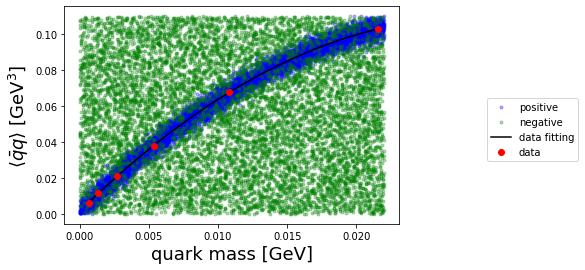

In [3]:
# data values
Hs, Ms = return_HM_npy('q-pp-highT-phys.csv') # data
# data fitting
f = np.poly1d(np.polyfit(Hs, Ms, deg=3)) # data fitting
# data augmentation (H_M_F = (x, y, 0/1) )
positive_H_M_F, negative_H_M_F = generate_training_data(data_size=10000, f=f)
# plot
plot_all(Hs, Ms, positive_H_M_F, negative_H_M_F, f)

## Reformat training data
To train a model by using PyTorch, the training data should be treated by a class called `Dataset`.

In [4]:
class Phi_Pi_DataSet(Dataset):
    ''' class for handling data '''
    def __init__(self, positive_H_M_F, negative_H_M_F, transform=None):
        self.phi = np.concatenate((positive_H_M_F[0], negative_H_M_F[0]),axis=0).astype(np.float32)
        self.Pi = np.concatenate((positive_H_M_F[1], negative_H_M_F[1]),axis=0).astype(np.float32)
        self.ans = np.concatenate((positive_H_M_F[2], negative_H_M_F[2]),axis=0).astype(np.float32)
        self.transform = transform

    def __getitem__(self, index):
        phi = self.phi[index]
        Pi = self.Pi[index]
        ans = self.ans[index]
        if self.transform is not None:
            phi = self.transform(phi)
            Pi = self.transform(Pi)
            ans = self.transform(ans)
        return phi, Pi, ans

    def __len__(self):
        return len(self.phi)

In [5]:
train_d_loader = DataLoader(Phi_Pi_DataSet(
                                           positive_H_M_F=positive_H_M_F, 
                                           negative_H_M_F=negative_H_M_F, 
                                           transform=transforms.Compose([torch.from_numpy])), 
                                           batch_size=100, shuffle=True)

# 2. Make a Neural network

Here we make the network (`Test`) and reguralization coefficients. For more details, please take a look at `network.py`.

In [15]:
# def phi_one_step(phi=None, Pi=None, del_eta=None):
#     ''' phi's eta evolution '''
#     return phi + del_eta*Pi 

# def Pi_one_step(phi=None, Pi=None, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Pi's eta evolution '''
#     return Pi +(-1)*del_eta*(Pi_W - phi_m2 - phi3_lam)

# def one_step(phi, Pi, Pi_W=None, phi_m2=None, phi3_lam = None, del_eta=None):
#     ''' Evolutions both phi and Pi '''
#     phi2 = phi_one_step(phi, Pi, del_eta)
#     Pi2 = Pi_one_step(phi, Pi, Pi_W=Pi_W, phi_m2=phi_m2, phi3_lam = phi3_lam, del_eta=del_eta)
#     return phi2, Pi2

def onestep(phi, Pi, hh=None, m2=None, lamb=None, del_eta=None):
    phi1 = phi + del_eta*Pi
    Pi1 = phi*m2*del_eta + (1-del_eta*hh)*Pi + del_eta*lamb*(phi1**3)
    return phi1, Pi1

def eta(s, eta_ini, eta_fin, N_layer):
    eta = eta_ini + (eta_fin - eta_ini)*(s-1)/N_layer
    return eta

# functions in final layers

def f(phi, Pi, eta=None):
    ''' returning Pi'''
    F=Pi
    return F

def arctan_scaled(x, center=None, scale=10, tanh=None):
    y = scale*(x-center)
    y = tanh(y)
    return y

def t(x, epsilon=None, tanh=None, dev=.01):
    ''' smoothed bump function '''
    left = -arctan_scaled(x, center=-epsilon, scale=1/dev, tanh=tanh)
    right = arctan_scaled(x, center=epsilon, scale=1/dev, tanh=tanh)
    lf = left+right
    return (lf+2)/2

##### 

class MetricNet(nn.Module):
    ''' class of model to be trained '''
    def __init__(self, Number_of_layers=None, eta_ini=None, eta_fin=None, m2=None, del_eta=None, d=None):
        super(MetricNet, self).__init__()
        # trained parameters
        Hs = []
        for layer_index in range(Number_of_layers):
            Hs.append(nn.Linear(1, 1, bias=False))
        self.Hs = nn.ModuleList(Hs)
        self.adsradius = nn.Linear(1, 1, bias=False)
        self.lamb = nn.Linear(1, 1, bias=False)
        # fixed parameters
        self.one = Variable(torch.ones(1)) # it would be better to use torch.nn.parameter.
        self.N_layers = Number_of_layers
        self.eta_ini = eta_ini
        self.eta_fin = eta_fin
        self.m2 = m2
        self.del_eta = del_eta
        self.d = d

    def show_lamb(self):
        return self.lamb(self.one)
    
    def show_adsradius(self):
        return self.adsradius(self.one)
        
    def penalty(self, coef_list=None):
        if coef_list==None:
            coefs = torch.autograd.Variable(torch.ones(self.N_layers))
        else:
            n_coef_list = np.array(coef_list, dtype=np.float32)
            coefs = torch.autograd.Variable(torch.from_numpy(n_coef_list))
        for i in range(self.N_layers):
            H = self.Hs[i]
            if H==self.Hs[0]:
                # making the metric at boundary as AdS_{d+1} 
                penalty = 0.001*(self.d - H(self.one))**2
                pH = H(self.one)
            else:
                # smoothing penalty
                ## if Einstein equation, use below:
                #penalty = penalty + coefs[i]*(-d**2 + (H(self.one) - pH)/del_eta + pH**2)**2
                penalty = penalty + coefs[i]*(H(self.one) - pH)**2
                pH = H(self.one)
        return penalty
        
    def forward(self, phi=None, Pi=None):
        ''' forward propagation '''
        # initial layer
        alphatilde = self.adsradius(self.one)*(1.7320508/(2*3.1415926))*phi
        betatilde = (self.adsradius(self.one))**3*(3.1415926/1.7320508)*Pi
        phi = alphatilde*(np.exp(-self.eta_ini)) + betatilde*(np.exp(-3*self.eta_ini)) -(1/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))
        Pi = -alphatilde*(np.exp(-self.eta_ini)) -3*betatilde*(np.exp(-3*self.eta_ini)) +(3/2)*alphatilde**3*self.lamb(self.one)*self.eta_ini*(np.exp(-3*self.eta_ini))-(1/2)*alphatilde**3*self.lamb(self.one)*(np.exp(-3*self.eta_ini))
        # intermediate layers
        for H in self.Hs:
            phi, Pi = onestep(phi, Pi, hh=H(self.one), m2=self.m2, lamb=self.lamb(self.one), del_eta=self.del_eta)
        # finaly layer
        f_ = f(phi, Pi, eta=eta(self.N_layers, self.eta_ini, self.eta_fin, self.N_layers))
        final = t(f_, epsilon=.1, tanh=torch.tanh)
        return final
    
    def loss1(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output*(2-answer), answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss
    def loss2(self, phi=None, Pi=None, answer=None, reg_coef_list=None):
        model_output = self.forward(phi=phi, Pi=Pi)
        loss = F.l1_loss(model_output, answer)**2
        loss = loss + self.penalty(coef_list=reg_coef_list)
        return loss
def init_weights(Model, d):
    ''' for initializations of parameters '''
    # metric (H[layer])
    for i in range(len(Model.Hs)):
        # ipt = initial value for H[i]
        ipt = d
        # noize 
        std = 3
        w = np.random.normal(ipt, std) # sampling from Gaussian
        w = round(w, 10) # it seems to be needed to round w somehow, I don't know why...
        Model.Hs[i].weight.data.fill_(w) # initialization excuted 
    
    # lambda
    lamb = 0.2
    std = 0
    lamb = np.random.normal(lamb, std)
    Model.lamb.weight.data.fill_(lamb)
    
    # AdS radius[GeV^{-1}]
    adsradius = 0.8
    std = 0
    adsradius = np.random.normal(adsradius, std)
    Model.adsradius.weight.data.fill_(adsradius)

In [35]:
# parameters
d = 4
m2 = -3 # mass^2
N_layer = 15
Delta_plus = d/2 +1
Delta_minus= d/2 -1
eta_fin = 1/N_layer
eta_ini = 1
del_eta = (eta_fin - eta_ini)/N_layer
# making network
Test = MetricNet(Number_of_layers=N_layer, 
                         eta_ini=eta_ini, 
                         eta_fin=eta_fin,
                         m2=m2, 
                         del_eta=del_eta,
                         d=d)
init_weights(Test, d)
# setting it to be trained
optimizer = optim.Adam(Test.parameters()) 
Test.train()
# For regularization terms
regularization_coeffs = [0] #(np.array([0, 1, 1, 1, 1, 1, 1, 1, 1,  1])*0.001).tolist()
for i in range(1, N_layer):
    regularization_coeffs.append(0.001*eta(i, eta_ini, eta_fin, N_layer)**4)
print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
print("H: ", np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

lambda: 0.20000000298023224,   AdS radius: 0.800000011920929[1/GeV]
H:  [ 2.5389345   0.15962356  5.859646   -0.7514848   4.9439807   5.873482
  7.5830784   1.8602109   5.16394     5.581896    8.316093    7.254916
  2.3587322  10.005531    0.6243588 ]


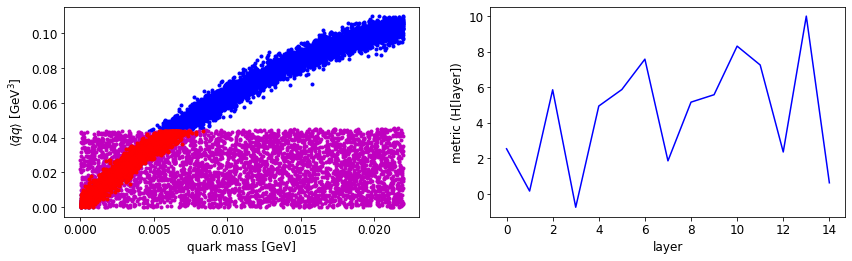

In [36]:
negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )

# 3. Train your NN

In [13]:
def plot_phase_and_metric(threshold=None, eta_or_layer='eta', positive_H_M_F=None, negative_H_M_F=None, Net=None):
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    negative_H = negative_H_M_F[0] #input_data[1]
    negative_M = negative_H_M_F[1] #input_data[3]
    
    phis = Variable(torch.from_numpy(negative_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(negative_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(negative_H[index])
            NN2_pos_Pis.append(negative_M[index])
        
    NN2_pos_phis_1 = np.array(NN2_pos_phis)
    NN2_pos_Pis_1 = np.array(NN2_pos_Pis)
    ######
    NN2_pos_phis = []
    NN2_pos_Pis = []
    
    positive_H = positive_H_M_F[0]# input_data[0]
    positive_M = positive_H_M_F[1]# input_data[2]
    
    phis = Variable(torch.from_numpy(positive_H.astype(np.float32)))
    Pis = Variable(torch.from_numpy(positive_M.astype(np.float32)))
    NN2_predicts = Net.forward(phi=phis, Pi=Pis).data.numpy()

    for index in range(len(phis)):
        value = NN2_predicts[index]#NN2.predict([phis[index], Pis[index]])
        if value < threshold:
            NN2_pos_phis.append(positive_H[index])
            NN2_pos_Pis.append(positive_M[index])
        
    NN2_pos_phis_2 = np.array(NN2_pos_phis)
    NN2_pos_Pis_2 = np.array(NN2_pos_Pis)
    ####
    plt.rcParams["font.size"] = 12
    fig = plt.figure(figsize=(14, 4))
    fig.subplots_adjust(bottom=0.15)
    al = fig.add_subplot(1,2,1)
    ar = fig.add_subplot(1,2,2)
    al.set_xlabel('quark mass [GeV]', fontsize=12)
    al.set_ylabel(r'$\langle \bar{q}q\rangle$ [GeV$^3$]', fontsize=12)
    al.plot(positive_H , positive_M, 'b.', label='NN(positive)=/=0')
    #print(NN2_pos_phis_1)
    al.plot(NN2_pos_phis_1 , NN2_pos_Pis_1, 'm.', label='NN(negative)=0')
    al.plot(NN2_pos_phis_2 , NN2_pos_Pis_2, 'r.', label='NN(positive)=0')
    al.tick_params(labelsize=12)
    #al.legend(loc="upper left")
    ##
    if eta_or_layer=='eta':
        x = etas
        ar.set_xlabel('eta', fontsize=12)
    else:
        x = np.arange(0,Net.N_layers,1)
        ar.set_xlabel('layer', fontsize=12)
    NN2_list = []
    for param in Net.Hs.parameters():
        w_py = (param.data.numpy().reshape(-1)).tolist()
        NN2_list.append(w_py)
    ar.set_ylabel('metric (H[layer])', fontsize=12)
    ar.plot(x, np.array(NN2_list), 'b-')#label='Emergent metric',lw=5, alpha=0.5)#/NN_list[0])
    ar.tick_params(labelsize=12)
    plt.show()
    return NN2_pos_phis_1, NN2_pos_Pis_1, NN2_pos_phis_2, NN2_pos_Pis_2, NN2_list

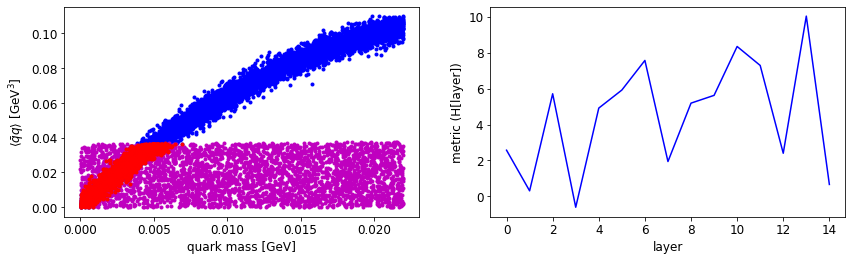

training epoch: 0,   loss: 0.3997782766819
lambda: 0.2731921374797821,   AdS radius: 0.8385226726531982[1/GeV]
[ 2.5704353   0.30646136  5.714757   -0.6075276   4.916826    5.9215508
  7.572099    1.9396929   5.192874    5.6258774   8.349424    7.292701
  2.400722   10.041046    0.6627626 ]


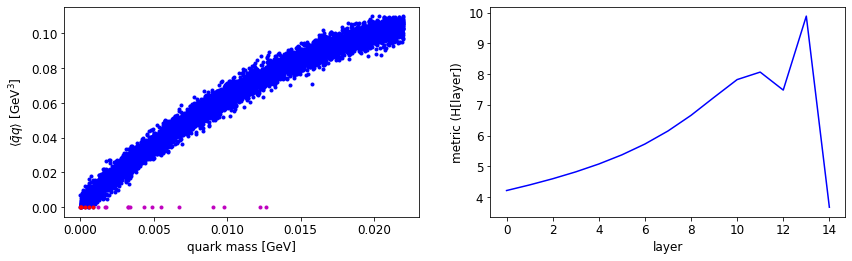

training epoch: 100,   loss: 0.252669095993042
lambda: 3.215522289276123,   AdS radius: 2.24836802482605[1/GeV]
[4.2114835 4.393885  4.5943627 4.8184814 5.074115  5.3715835 5.724261
 6.1481576 6.6572366 7.2444324 7.8205466 8.06442   7.4795094 9.885416
 3.6679075]


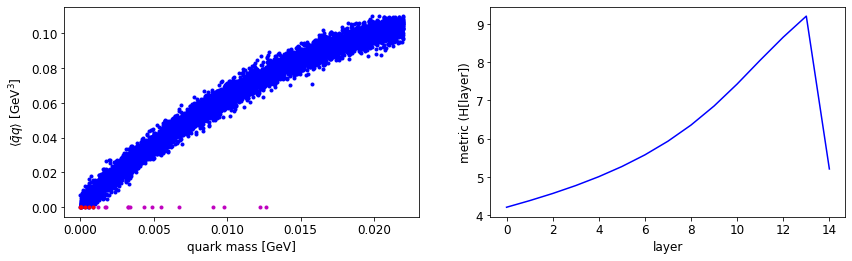

training epoch: 200,   loss: 0.253438800573349
lambda: 4.878003120422363,   AdS radius: 2.24212384223938[1/GeV]
[4.2073565 4.379719  4.566937  4.7741327 5.0066905 5.2713566 5.576907
 5.934415  6.3565745 6.8546047 7.429421  8.05245   8.655012  9.205226
 5.208764 ]


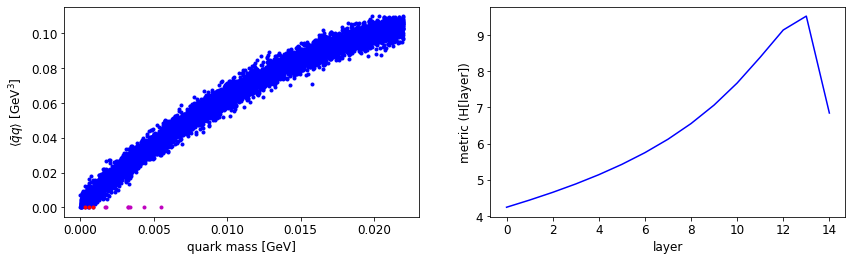

training epoch: 300,   loss: 0.25331321358680725
lambda: 6.587819576263428,   AdS radius: 2.305330991744995[1/GeV]
[4.2402716 4.438903  4.6522093 4.8843393 5.140225  5.425985  5.749533
 6.1212206 6.5545173 7.0664916 7.675805  8.38936   9.143374  9.527356
 6.8465605]


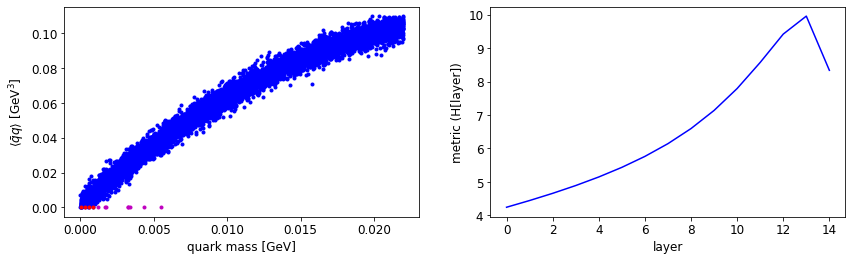

training epoch: 400,   loss: 0.2530785799026489
lambda: 8.19489574432373,   AdS radius: 2.161308765411377[1/GeV]
[4.2406907 4.4419255 4.6569576 4.890155  5.146873  5.434398  5.762468
 6.143889  6.595339  7.137731  7.793741  8.574549  9.422918  9.961272
 8.339183 ]


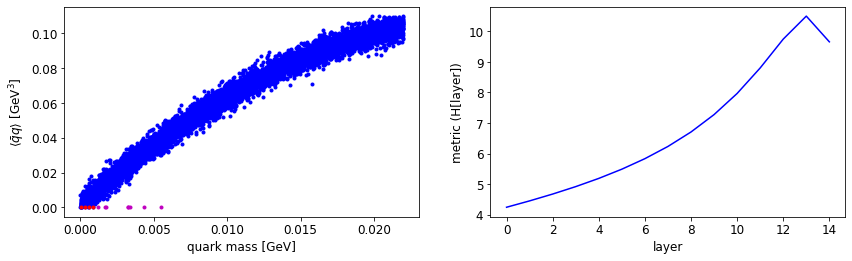

training epoch: 500,   loss: 0.2529691457748413
lambda: 9.677098274230957,   AdS radius: 2.0389292240142822[1/GeV]
[ 4.2470236  4.455088   4.6784377  4.9214997  5.189982   5.4912643
  5.835167   6.234787   6.7075553  7.27608    7.9670715  8.801113
  9.744119  10.495635   9.654708 ]


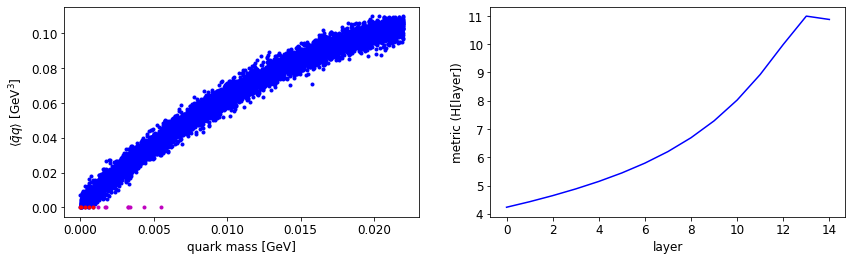

training epoch: 600,   loss: 0.2530204653739929
lambda: 11.075151443481445,   AdS radius: 1.964560627937317[1/GeV]
[ 4.232766   4.4280715  4.643473   4.880783   5.1455207  5.445963
  5.793149   6.2017894  6.6915455  7.2882357  8.023586   8.927531
  9.989875  10.9930315 10.874507 ]


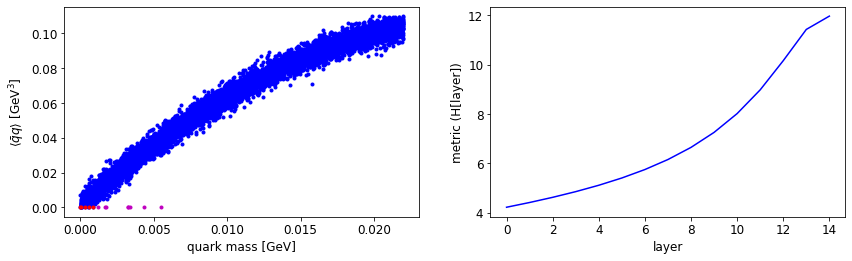

training epoch: 700,   loss: 0.2532762885093689
lambda: 12.422224998474121,   AdS radius: 1.9258373975753784[1/GeV]
[ 4.2242966  4.4165926  4.6256695  4.8561044  5.1141686  5.4084063
  5.7504587  6.15623    6.6475525  7.254264   8.015571   8.976173
 10.157237  11.422205  11.961254 ]


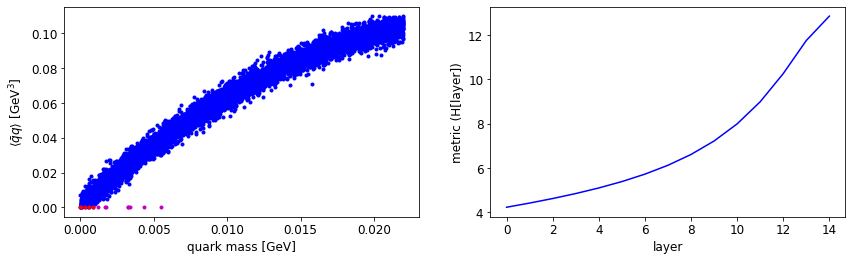

training epoch: 800,   loss: 0.2532142400741577
lambda: 13.716289520263672,   AdS radius: 1.891261100769043[1/GeV]
[ 4.2270765  4.415959   4.620707   4.845855   5.0981045  5.386394
  5.722618   6.123239   6.6114216  7.2198353  7.993776   8.991501
 10.266176  11.760976  12.862993 ]


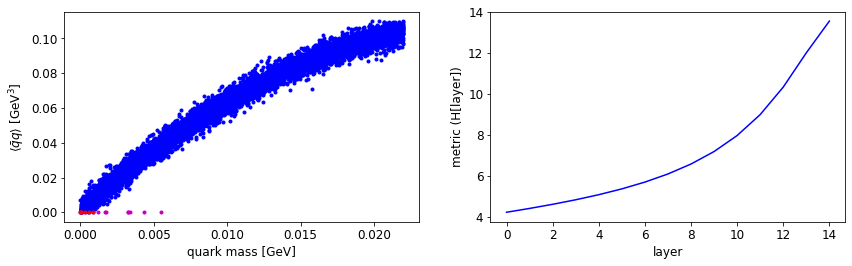

training epoch: 900,   loss: 0.25290700793266296
lambda: 14.931669235229492,   AdS radius: 1.8651639223098755[1/GeV]
[ 4.214851   4.401408   4.603036   4.8246284  5.072972   5.356995
  5.688958   6.0859623  6.5721784  7.1820974  7.965016   8.989021
 10.332792  12.007341  13.55822  ]


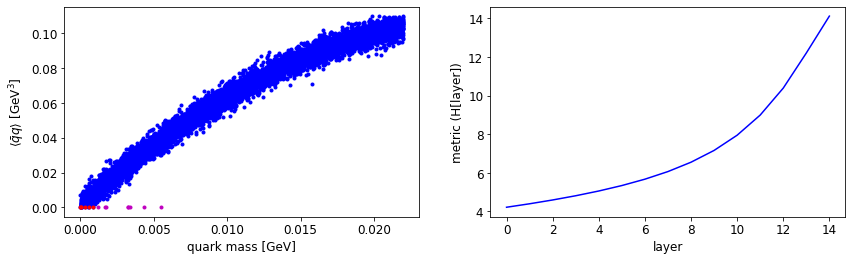

training epoch: 1000,   loss: 0.252782940864563
lambda: 16.1207332611084,   AdS radius: 1.8457539081573486[1/GeV]
[ 4.2203727  4.3999133  4.5970836  4.8156853  5.061707   5.343642
  5.6734676  6.068242   6.5526223  7.1625533  7.950827   8.99373
 10.390539  12.2074    14.119295 ]


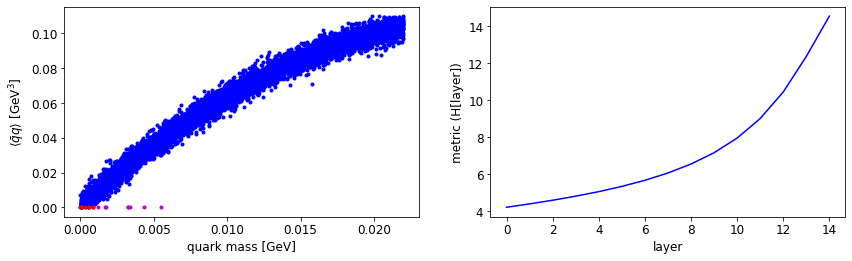

training epoch: 1100,   loss: 0.25295770168304443
lambda: 17.264881134033203,   AdS radius: 1.824090600013733[1/GeV]
[ 4.2153378  4.3961554  4.594361   4.8136697  5.060071   5.342194
  5.6722074  6.067287   6.5521774  7.1634135  7.9559274  9.012108
 10.447082  12.369044  14.551549 ]


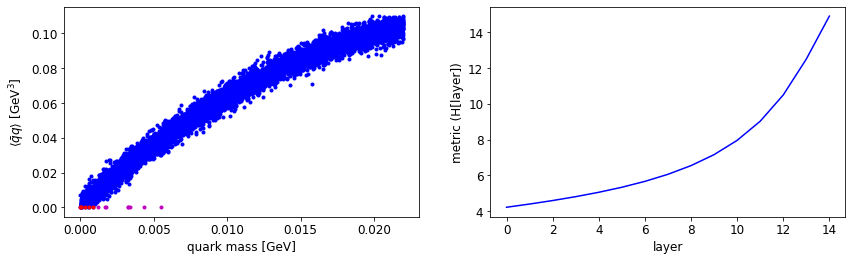

training epoch: 1200,   loss: 0.2532977759838104
lambda: 18.380512237548828,   AdS radius: 1.806372880935669[1/GeV]
[ 4.213545   4.3926096  4.5886     4.8056445  5.0501704  5.331038
  5.6603856  6.0553966  6.5410695  7.154738   7.9531775  9.023063
 10.491115  12.499043  14.901792 ]


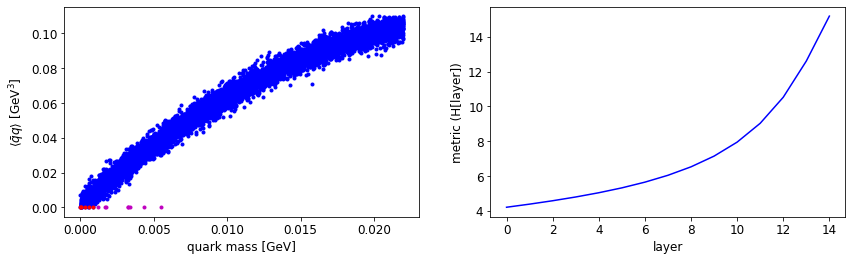

training epoch: 1300,   loss: 0.2526111900806427
lambda: 19.467082977294922,   AdS radius: 1.796420693397522[1/GeV]
[ 4.205058   4.383774   4.578828   4.794887   5.038534   5.318515
  5.647069   6.0416455  6.527737   7.143457   7.9471397  9.02919
 10.525946  12.605862  15.189371 ]


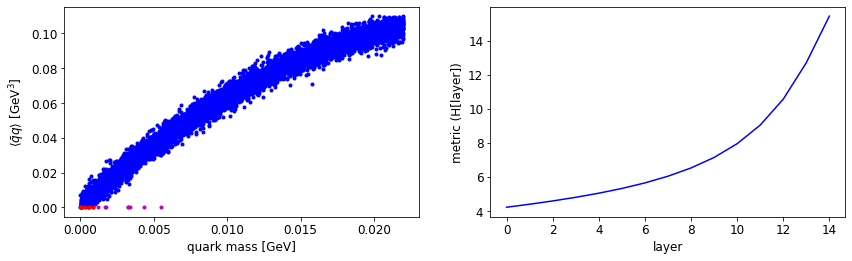

training epoch: 1400,   loss: 0.2533456087112427
lambda: 20.544862747192383,   AdS radius: 1.7925987243652344[1/GeV]
[ 4.2145767  4.391189   4.5842223  4.798002   5.0391235  5.316764
  5.6432996  6.036278   6.521406   7.13741    7.9442444  9.035922
 10.557368  12.699588  15.436309 ]


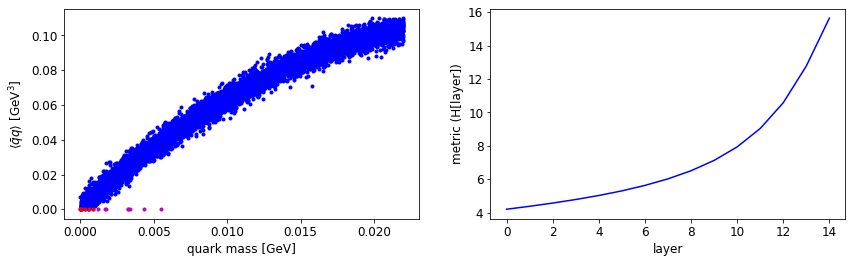

training epoch: 1500,   loss: 0.25298553705215454
lambda: 21.61200523376465,   AdS radius: 1.7885252237319946[1/GeV]
[ 4.213241   4.3899264  4.582028   4.794825   5.035137   5.311981
  5.637719   6.029957   6.5146127  7.1309714  7.940186   9.039266
 10.580725  12.775329  15.641168 ]


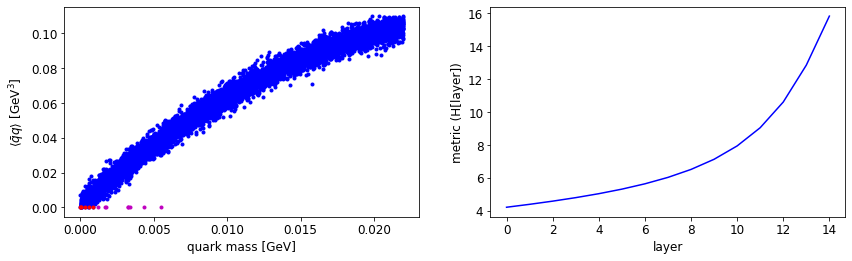

training epoch: 1600,   loss: 0.25336670875549316
lambda: 22.679325103759766,   AdS radius: 1.7840632200241089[1/GeV]
[ 4.2151413  4.3925047  4.585211   4.7981224  5.037835   5.313369
  5.6372356  6.027383   6.510303   7.1260605  7.93695    9.042329
 10.600888  12.84016   15.816696 ]


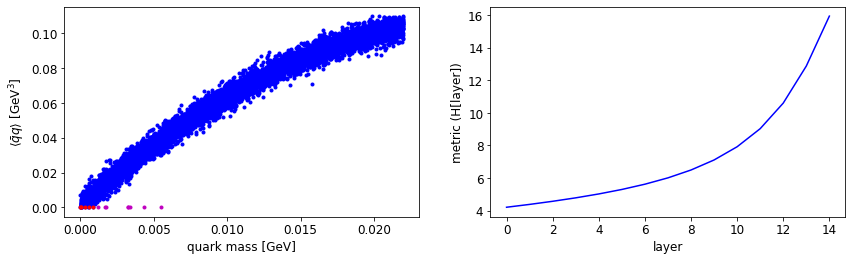

training epoch: 1700,   loss: 0.2529519498348236
lambda: 23.72490119934082,   AdS radius: 1.772600531578064[1/GeV]
[ 4.2028627  4.3773594  4.5688233  4.78084    5.0199738  5.295158
  5.6187735  6.008686   6.4914765  7.1075926  7.9201846  9.030666
 10.603117  12.879441  15.948118 ]


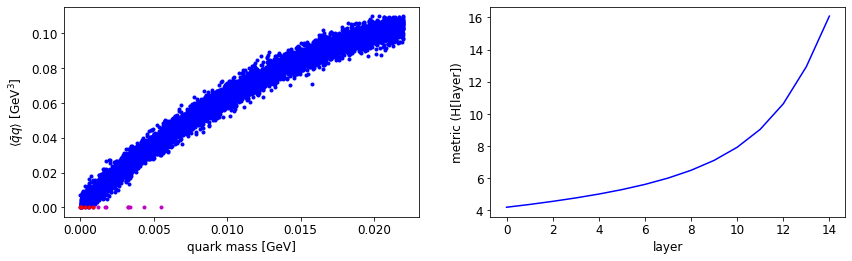

training epoch: 1800,   loss: 0.25285735726356506
lambda: 24.770612716674805,   AdS radius: 1.7679353952407837[1/GeV]
[ 4.2020736  4.3755226  4.567369   4.7802706  5.020141   5.2960067
  5.620463   6.0114274  6.495302   7.112336   7.9261155  9.040024
 10.62312   12.929387  16.073639 ]


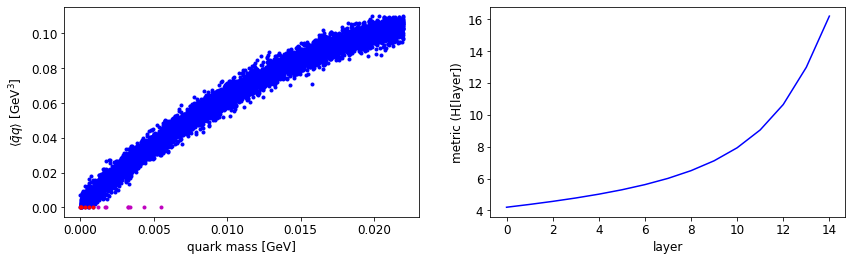

training epoch: 1900,   loss: 0.25288277864456177
lambda: 25.814098358154297,   AdS radius: 1.7691551446914673[1/GeV]
[ 4.2029986  4.379197   4.5705166  4.7823734  5.0214715  5.2967772
  5.6208134  6.011548   6.495561   7.113497   7.9295783  9.048307
 10.6417675 12.973847  16.18251  ]


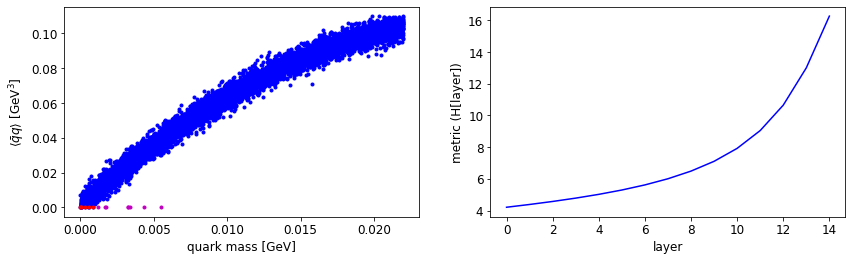

training epoch: 2000,   loss: 0.25279510021209717
lambda: 26.852725982666016,   AdS radius: 1.7698785066604614[1/GeV]
[ 4.2075887  4.382558   4.5726085  4.783309   5.020933   5.294355
  5.616284   6.0050097  6.4875293  7.1050096  7.9223304  9.045064
 10.648142  13.002977  16.26625  ]


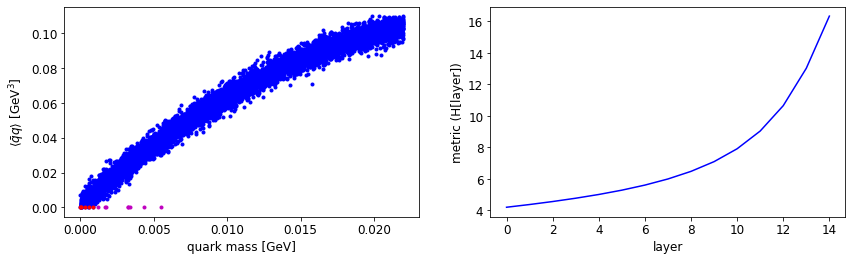

training epoch: 2100,   loss: 0.25305911898612976
lambda: 27.882110595703125,   AdS radius: 1.7680836915969849[1/GeV]
[ 4.2057753  4.3784533  4.5680285  4.778435   5.015993   5.2895474
  5.6115985  6.0002813  6.482519   7.099609   7.916986   9.041655
 10.651561  13.025414  16.334673 ]


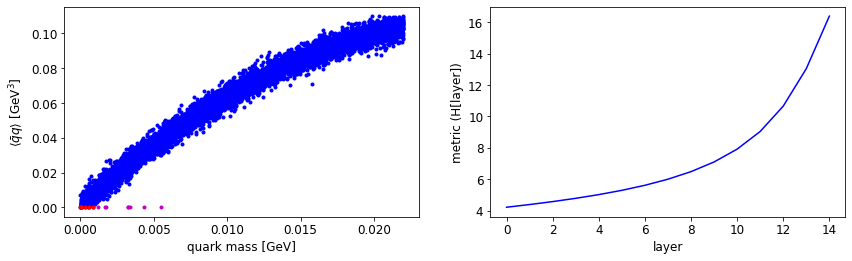

training epoch: 2200,   loss: 0.25269150733947754
lambda: 28.912309646606445,   AdS radius: 1.7670108079910278[1/GeV]
[ 4.2086296  4.3806534  4.5684757  4.777391   5.01385    5.28654
  5.607892   5.9960384  6.4779544  7.095028   7.912926   9.039402
 10.654788  13.044104  16.392208 ]


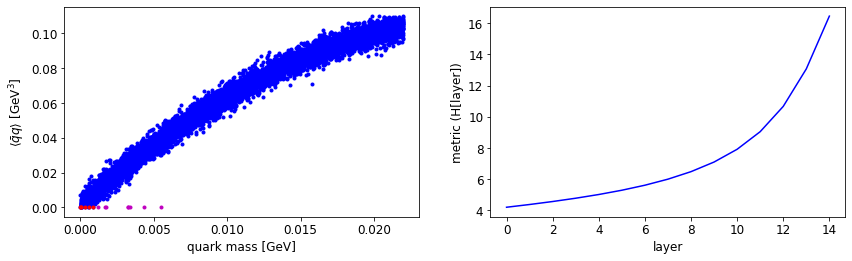

training epoch: 2300,   loss: 0.25291919708251953
lambda: 29.944032669067383,   AdS radius: 1.763291358947754[1/GeV]
[ 4.207627   4.383125   4.574302   4.7856517  5.0235734  5.296942
  5.618358   6.0060544  6.487102   7.1031146  7.920253   9.047258
 10.66664   13.068291  16.448458 ]


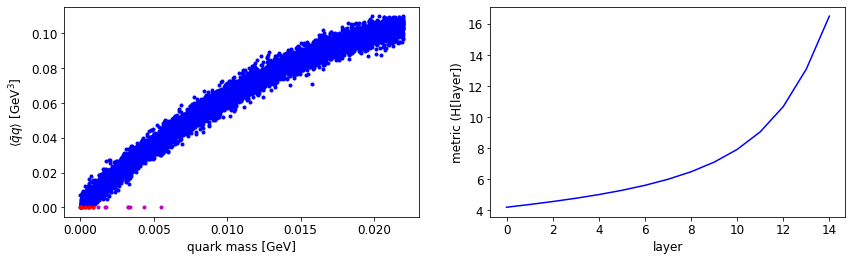

training epoch: 2400,   loss: 0.2526825964450836
lambda: 30.969987869262695,   AdS radius: 1.7636140584945679[1/GeV]
[ 4.204804   4.3810596  4.570733   4.7807736  5.018078   5.291411
  5.6132636  6.0017805  6.483979   7.101387   7.9201255  9.049222
 10.672431  13.08431   16.491    ]


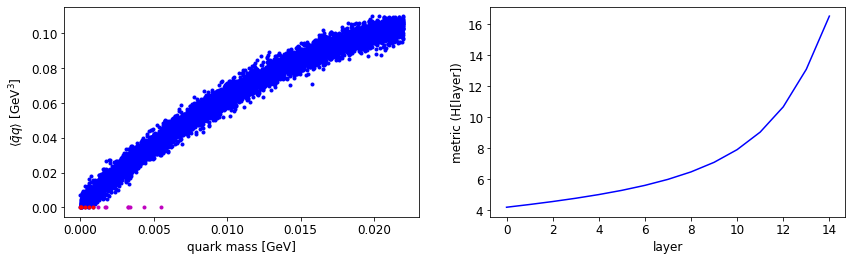

training epoch: 2500,   loss: 0.25291144847869873
lambda: 31.9991397857666,   AdS radius: 1.7548640966415405[1/GeV]
[ 4.2063303  4.3830585  4.574351   4.785411   5.022881   5.2956657
  5.6164465  6.0036426  6.484606   7.101225   7.9200177  9.050456
 10.677323  13.098155  16.527058 ]


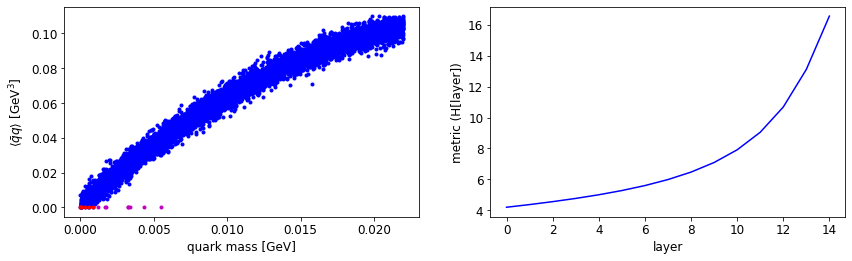

training epoch: 2600,   loss: 0.2531624138355255
lambda: 33.02055740356445,   AdS radius: 1.755653738975525[1/GeV]
[ 4.2016106  4.374258   4.5629826  4.772042   5.0081196  5.2803817
  5.601535   5.9898715  6.472511   7.0910177  7.9117026  9.044315
 10.674707  13.103568  16.551558 ]


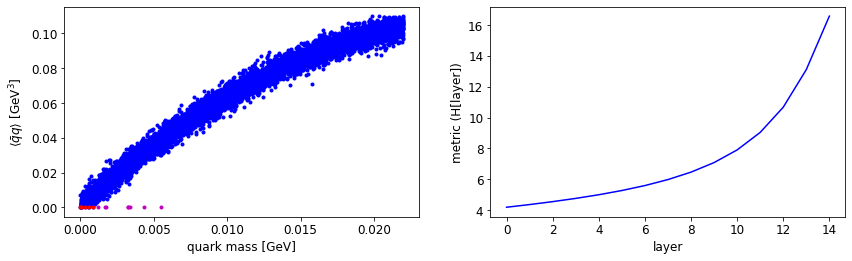

training epoch: 2700,   loss: 0.2528877556324005
lambda: 34.03831481933594,   AdS radius: 1.750873327255249[1/GeV]
[ 4.1945324  4.3680444  4.5575776  4.767579   5.0045843  5.2774367
  5.5987034  5.986633   6.468456   7.0861173  7.9064546  9.039855
 10.673174  13.108936  16.57262  ]


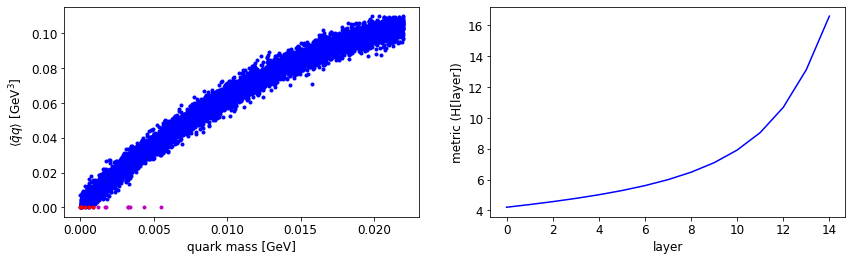

training epoch: 2800,   loss: 0.25269216299057007
lambda: 35.06126403808594,   AdS radius: 1.7618283033370972[1/GeV]
[ 4.2098355  4.3835497  4.572953   4.782698   5.019218   5.2913027
  5.6115522  5.9984055  6.479345   7.096472   7.9167953  9.050877
 10.686253  13.127703  16.604885 ]


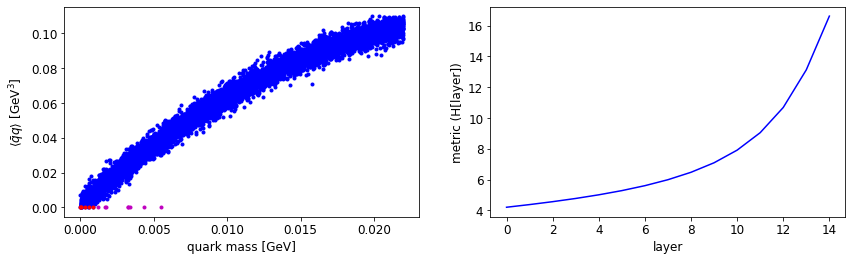

training epoch: 2900,   loss: 0.2525973916053772
lambda: 36.07860565185547,   AdS radius: 1.7529128789901733[1/GeV]
[ 4.2013845  4.374482   4.5631065  4.7724338  5.008971   5.2815113
  5.602589   5.9904437  6.472238   7.0898395  7.910217   9.044394
 10.681049  13.126928  16.615564 ]


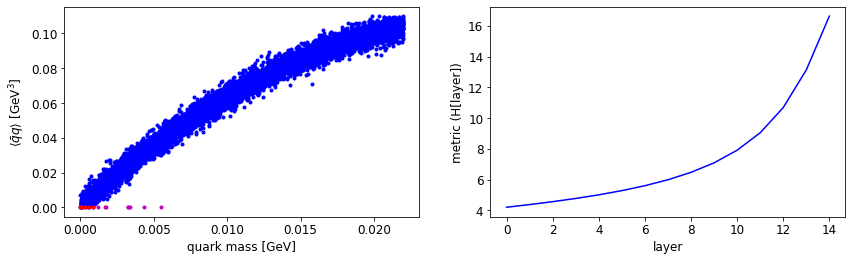

training epoch: 3000,   loss: 0.2530215382575989
lambda: 37.099666595458984,   AdS radius: 1.7563154697418213[1/GeV]
[ 4.2015233  4.375365   4.564464   4.7734456  5.009276   5.2812004
  5.601836   5.989329   6.4708285  7.088379   7.9091754  9.044365
 10.682793  13.132521  16.630571 ]


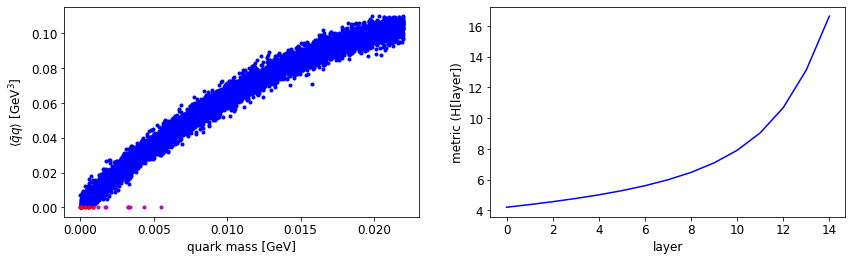

training epoch: 3100,   loss: 0.2528102993965149
lambda: 38.112945556640625,   AdS radius: 1.7523319721221924[1/GeV]
[ 4.205912   4.378907   4.567572   4.7768307  5.0131884  5.285494
  5.6062045  5.993452   6.4744267  7.091268   7.911375   9.04629
 10.685481  13.138259  16.644117 ]


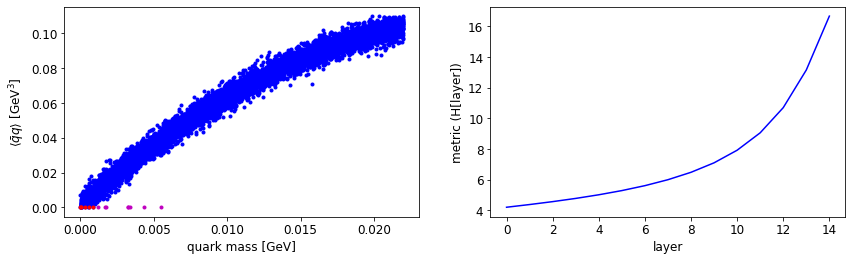

training epoch: 3200,   loss: 0.2531186044216156
lambda: 39.1234130859375,   AdS radius: 1.754026174545288[1/GeV]
[ 4.199292   4.375404   4.565318   4.7750826  5.0119915  5.285014
  5.606628   5.9950075  6.4773374  7.0955186  7.916607   9.05201
 10.691874  13.1468935 16.659143 ]


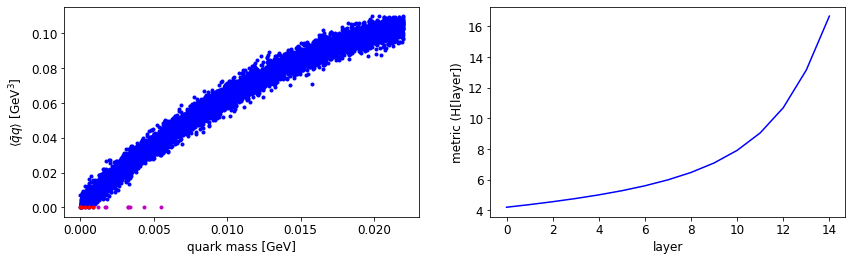

training epoch: 3300,   loss: 0.25310370326042175
lambda: 40.13534164428711,   AdS radius: 1.7536553144454956[1/GeV]
[ 4.2007504  4.373226   4.5617623  4.770887   5.0069566  5.2788806
  5.5994043  5.9869847  6.4690275  7.0876594  7.9099407  9.047074
 10.688774  13.146351  16.664015 ]


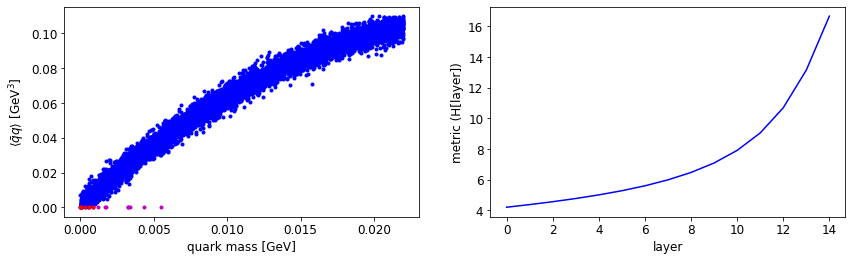

training epoch: 3400,   loss: 0.2528328597545624
lambda: 41.150535583496094,   AdS radius: 1.7509586811065674[1/GeV]
[ 4.1975656  4.3702335  4.5585356  4.7672315  5.0031495  5.2753425
  5.5963235  5.984244   6.4663334  7.08466    7.906512   9.043568
 10.686359  13.146414  16.66885  ]


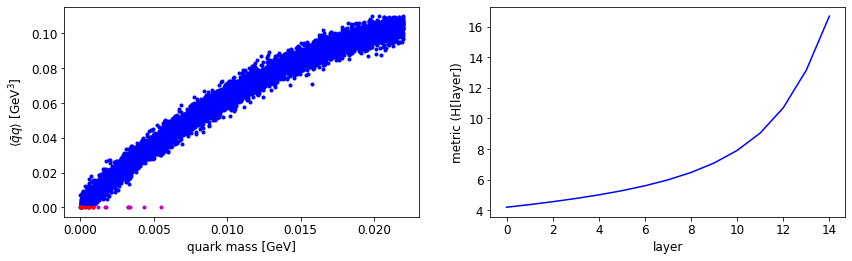

training epoch: 3500,   loss: 0.25258100032806396
lambda: 42.166893005371094,   AdS radius: 1.754775047302246[1/GeV]
[ 4.204572   4.376938   4.566219   4.7761045  5.0125585  5.2845526
  5.6049113  5.992102   6.473501   7.091263   7.9127464  9.049773
 10.692987  13.154814  16.681326 ]


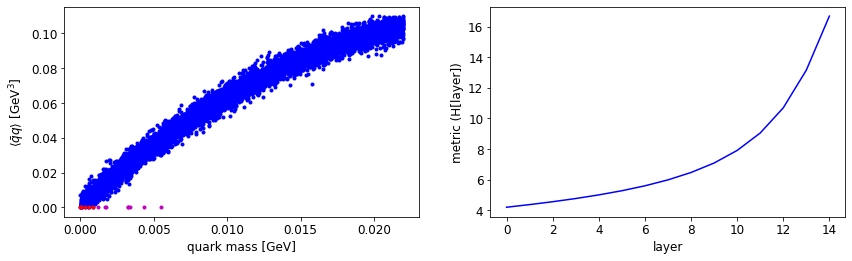

training epoch: 3600,   loss: 0.25272923707962036
lambda: 43.175880432128906,   AdS radius: 1.7501592636108398[1/GeV]
[ 4.198357   4.3709717  4.559143   4.7680697  5.0043254  5.2767673
  5.597869   5.985801   6.4677906  7.085911   7.907564   9.044709
 10.688278  13.1514225 16.681452 ]


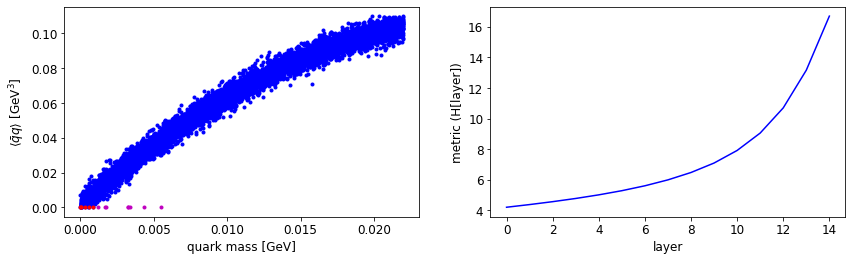

training epoch: 3700,   loss: 0.25278860330581665
lambda: 44.18873596191406,   AdS radius: 1.7545928955078125[1/GeV]
[ 4.201047   4.375936   4.5655355  4.775051   5.011137   5.2828875
  5.6031346  5.9903445  6.4719267  7.0900316  7.911971   9.049567
 10.693692  13.157924  16.69096  ]


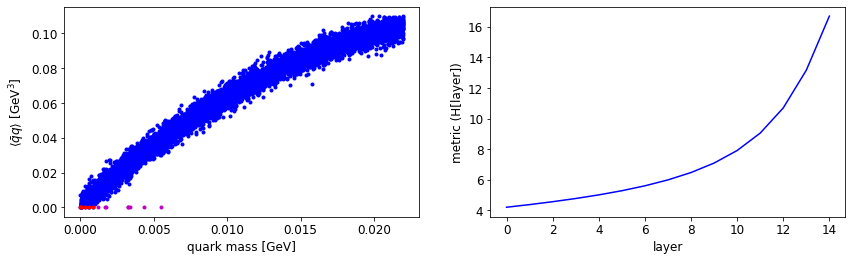

training epoch: 3800,   loss: 0.2533632516860962
lambda: 45.20326614379883,   AdS radius: 1.7484368085861206[1/GeV]
[ 4.2019644  4.3752904  4.5643935  4.773803   5.010026   5.28192
  5.6021514  5.9891453  6.470363   7.088009   7.909552   9.046974
 10.691415  13.15661   16.691986 ]


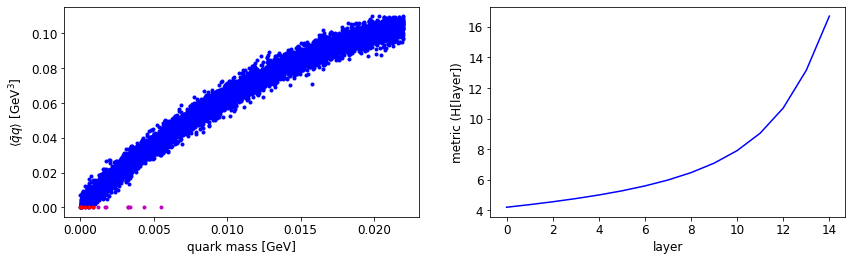

training epoch: 3900,   loss: 0.25276434421539307
lambda: 46.21113586425781,   AdS radius: 1.7548052072525024[1/GeV]
[ 4.2083545  4.378587   4.5657606  4.7736216  5.0085526  5.2796917
  5.599762   5.9870405  6.468808   7.0871706  7.909472   9.047534
 10.692551  13.158598  16.695812 ]


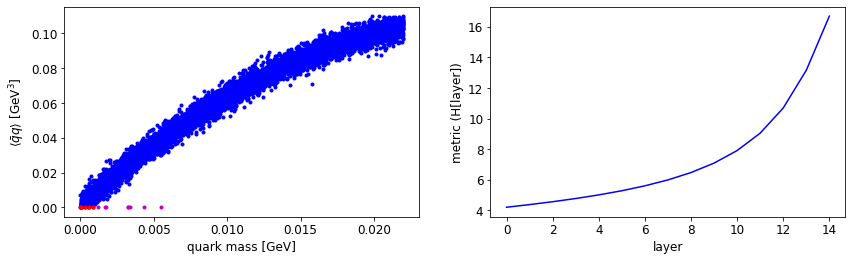

training epoch: 4000,   loss: 0.25316399335861206
lambda: 47.225425720214844,   AdS radius: 1.752066969871521[1/GeV]
[ 4.200789   4.373827   4.5625114  4.771717   5.0079165  5.280019
  5.6005993  5.9879107  6.4692574  7.0868564  7.9083033  9.045828
 10.690883  13.157739  16.696667 ]


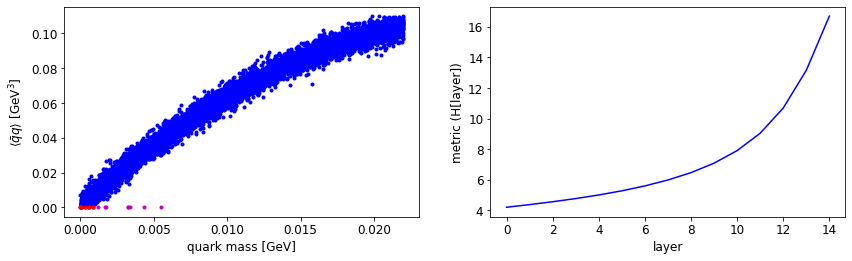

training epoch: 4100,   loss: 0.253315806388855
lambda: 48.242305755615234,   AdS radius: 1.7563036680221558[1/GeV]
[ 4.202741   4.37467    4.562194   4.7702494  5.0054216  5.27671
  5.5967484  5.983866   6.4653945  7.0834365  7.9053383  9.04317
 10.68841   13.155705  16.696175 ]


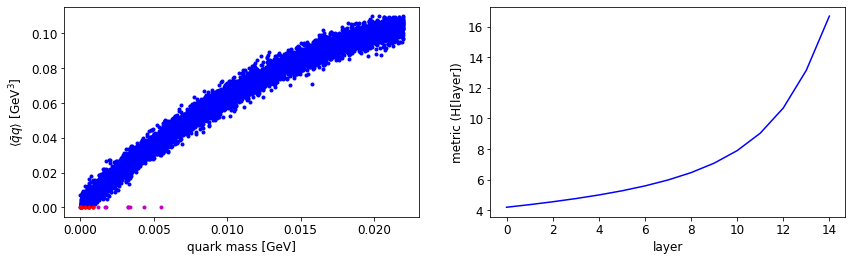

training epoch: 4200,   loss: 0.25311368703842163
lambda: 49.2530517578125,   AdS radius: 1.751199722290039[1/GeV]
[ 4.1968136  4.366498   4.5539794  4.762538   4.9981923  5.269837
  5.590032   5.977002   6.4580555  7.07543    7.8967295  9.034197
 10.6793585 13.147107  16.688784 ]


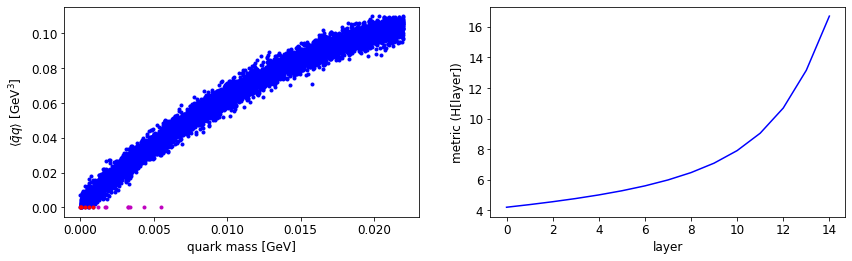

training epoch: 4300,   loss: 0.2526569068431854
lambda: 50.27122497558594,   AdS radius: 1.7557059526443481[1/GeV]
[ 4.2013645  4.3736725  4.5622034  4.7709045  5.006382   5.277853
  5.5979857  5.985004   6.4661064  7.0833673  7.9042573  9.041006
 10.685591  13.153178  16.695646 ]


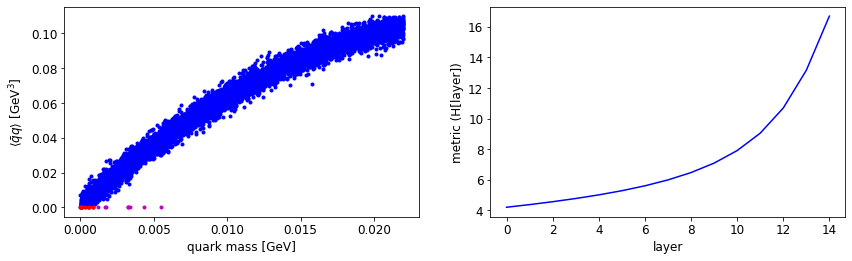

training epoch: 4400,   loss: 0.2529579699039459
lambda: 51.293556213378906,   AdS radius: 1.7520004510879517[1/GeV]
[ 4.2038527  4.3761826  4.5658145  4.7759156  5.0124407  5.2842665
  5.6040883  5.9903646  6.4706283  7.0871863  7.907595   9.044036
 10.688222  13.155379  16.698208 ]


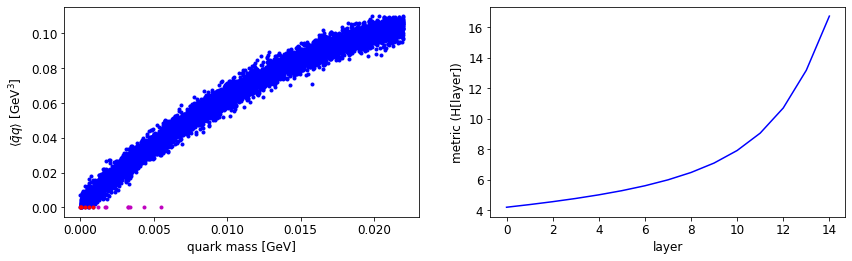

training epoch: 4500,   loss: 0.2529490888118744
lambda: 52.31194305419922,   AdS radius: 1.7519721984863281[1/GeV]
[ 4.2070117  4.380884   4.57078    4.781112   5.0181837  5.2907906
  5.6115375  5.9987917  6.4799213  7.097144   7.9179206  9.054343
 10.698132  13.164877  16.707684 ]


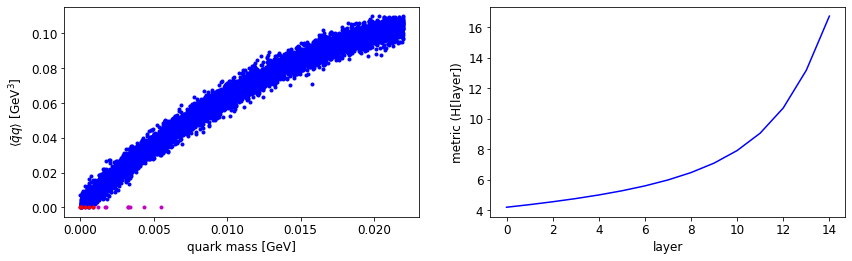

training epoch: 4600,   loss: 0.25298526883125305
lambda: 53.32467269897461,   AdS radius: 1.7600103616714478[1/GeV]
[ 4.208545   4.3794646  4.5669885  4.7755966  5.0116305  5.28398
  5.6051474  5.993346   6.4758825  7.0949006  7.917629   9.055793
 10.700664  13.167777  16.710684 ]


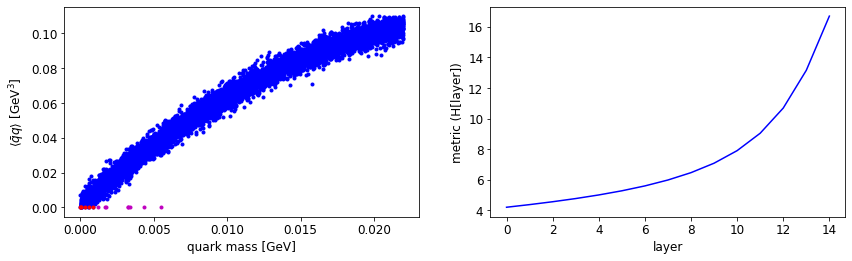

training epoch: 4700,   loss: 0.252877414226532
lambda: 54.33139419555664,   AdS radius: 1.751834511756897[1/GeV]
[ 4.202245   4.374369   4.5624332  4.770939   5.0063148  5.277524
  5.5972114  5.9836965  6.4643774  7.0816627  7.903334   9.041593
 10.687648  13.155912  16.699251 ]


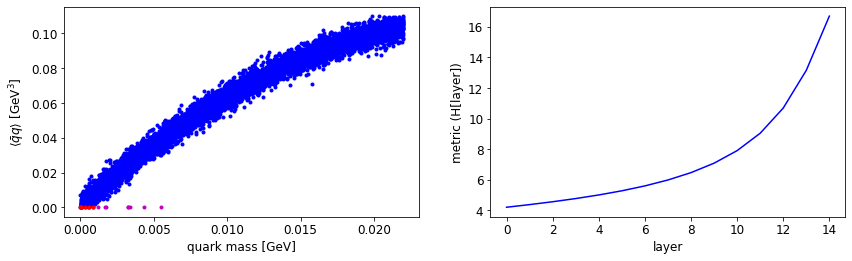

training epoch: 4800,   loss: 0.25335705280303955
lambda: 55.344078063964844,   AdS radius: 1.757318377494812[1/GeV]
[ 4.2038856  4.376334   4.563847   4.772032   5.0075636  5.279172
  5.599283   5.9861355  6.4670687  7.0843477  7.9055886  9.043061
 10.6885805 13.157225  16.701212 ]


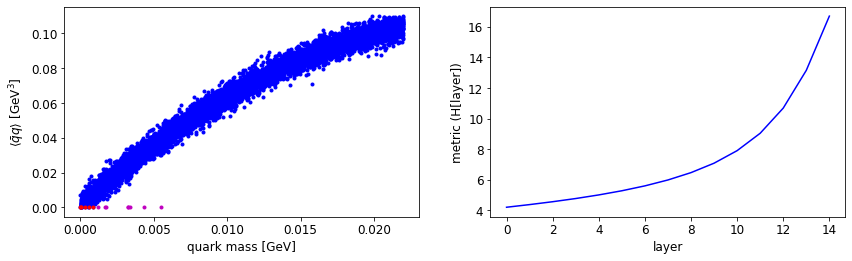

training epoch: 4900,   loss: 0.2535656988620758
lambda: 56.36046600341797,   AdS radius: 1.750430941581726[1/GeV]
[ 4.2034893  4.376698   4.564753   4.7733364  5.009018   5.2805386
  5.6003613  5.9866815  6.4668493  7.0831914  7.9034696  9.040096
 10.684921  13.153255  16.697678 ]


In [37]:
total_epoch=5000
show_epoch_each=100

for epoch in range(total_epoch):
    batches = iter(train_d_loader)
    train_loss = 0.0
    for (b_phi, b_Pi, b_ans) in batches:
        phi, Pi, ans = Variable(b_phi), Variable(b_Pi), Variable(b_ans)
        loss = Test.loss2(phi=phi, Pi=Pi, answer=ans, reg_coef_list=regularization_coeffs)
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        train_loss += loss.data[0]
    if np.isnan(train_loss)==True: break

    if epoch % show_epoch_each == 0:
        negx, negy, posx, posy, Hs = plot_phase_and_metric(
                                                           threshold=.1, eta_or_layer='layer',
                                                           positive_H_M_F=positive_H_M_F,
                                                           negative_H_M_F=negative_H_M_F,
                                                           Net=Test
                                                          )
        print ("training epoch: {},   loss: {}".format(epoch, train_loss / len(train_d_loader)))
        print ("lambda: {},   AdS radius: {}[1/GeV]".format(Test.show_lamb().data.numpy()[0], Test.show_adsradius().data.numpy()[0]))
        print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

In [ ]:
print(np.array([Test.Hs[i](Test.one).data.numpy()[0] for i in range (Test.N_layers)]))

# 4. Save & load NN

Create a directry named "trained_models" by running the following cell:

In [ ]:
%%bash
mkdir trained_models

Instance "Test" of the trained MetricNet is saved there by using `torch.save`.

In [ ]:
torch.save(Test, 'trained_models/name.pt') 

To load a saved model, use `torch.load`.

In [ ]:
model = torch.load('trained_models/name.pt')

# 5. How to get trained parameters of the NN

To get the parameters as numpy array, use:

In [ ]:
model.adsradius.weight.data.numpy() # AdS radius in unit [GeV^{-1}]

In [ ]:
model.lamb.weight.data.numpy() # lambda

In [ ]:
for h in model.Hs:     # metric (h)
    np_h = h.weight.data.numpy()
    print(np_h)